<a href="https://colab.research.google.com/github/yoonwanggyu/Self_Study/blob/main/8%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 강아지 / 고양이 분류 실습 - 캐글

# Kaggle API로 데이터 가져와 분류 모델 만들기

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir ~/.kaggle_
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 808M/812M [00:23<00:00, 42.1MB/s]
100% 812M/812M [00:23<00:00, 35.9MB/s]


**train데이터만 가지고 0 ~ 1000까지는 훈련용 1000 ~ 1500까지는 평가용 1500 ~ 2500까지는 테스트용**

In [69]:
!unzip /content/drive/MyDrive/train.zip

Archive:  /content/drive/MyDrive/train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os,shutil,pathlib

orginial_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")
def make_subset(subset_name,start_index,end_index):
    for category in ("cat","dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index,end_index)]

        for fname in fnames:
            shutil.copyfile(src = orginial_dir / fname,
                            dst = dir / fname)

make_subset("train",start_index = 0, end_index = 1000)
make_subset("validation",start_index = 1000, end_index = 1500)
make_subset("test",start_index=1500,end_index=2500)

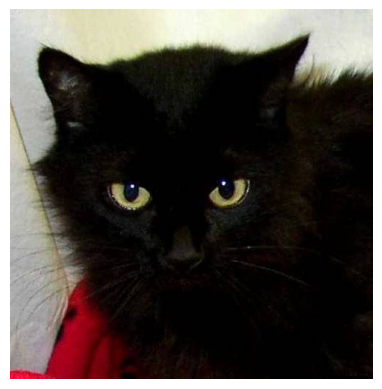

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "/content/cats_vs_dogs_small/test/cat/cat.1500.jpg"
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off') # 축 제거
plt.show()

**모델 생성**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180,180,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3,activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs=inputs,outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['accuracy'])

**데이터 전처리**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir / 'train',    # 자동 RGB 3차원으로 바꿔줌
                                             image_size=(180,180),      # 사이즈 바꾸고
                                             batch_size=32)             # batch size 32로
validation_dataset = image_dataset_from_directory(new_base_dir / 'validation',
                                             image_size=(180,180),
                                             batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / 'test',
                                             image_size=(180,180),
                                             batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
for data_batch,labels_batch in train_dataset:
    print("데이터 배치 크기: ",data_batch.shape)
    print("레이블 배치 크기: ",labels_batch.shape)
    break

데이터 배치 크기:  (32, 180, 180, 3)
레이블 배치 크기:  (32,)


**모델 훈련**

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch.h5",
                                            save_best_only = True,
                                            monitor = "val_loss")]

history = model.fit(train_dataset,
                    epochs=30,
                    validation_data = validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 93ms/step - loss: 0.7121 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.6190
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 8s 112ms/step - loss: 0.6955 - accuracy: 0.5275 - val_loss: 0.6990 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6848 - accuracy: 0.5750 - val_loss: 0.6612 - val_accuracy: 0.6610
Epoch 4/30
63/63 [==============================] - 4s 66ms/step - loss: 0.6309 - accuracy: 0.6410 - val_loss: 0.6133 - val_accuracy: 0.6400
Epoch 5/30
63/63 [==============================] - 7s 110ms/step - loss: 0.6071 - accuracy: 0.6675 - val_loss: 0.5882 - val_accuracy: 0.6660
Epoch 6/30
63/63 [==============================] - 4s 66ms/step - loss: 0.5748 - accuracy: 0.6960 - val_loss: 0.5851 - val_accuracy: 0.6720
Epoch 7/30
63/63 [==============================] - 5s 69ms/step - loss: 0.5446 - accuracy: 0.7250 - val_loss: 0.5772 - val_accuracy: 0.6770
Epoch 8/30
63/63 [==============================] - 7s 106ms/step - loss: 0.5084 - accuracy: 0.7480 - val_loss: 0.5631 - val_accuracy: 0.7110
Epoch 9/30
63/63 [===

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**모델 시각화 -> 과대적합 발생**

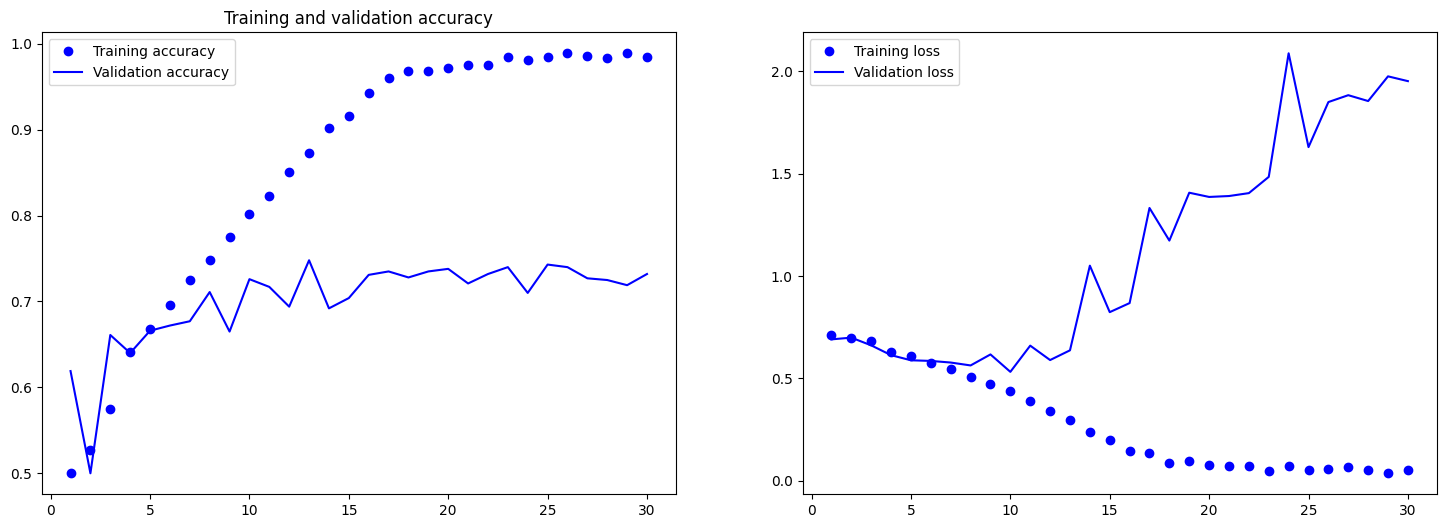

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1,len(accuracy)+1)

plt.plot(epoch,accuracy,'bo',label = 'Training accuracy')
plt.plot(epoch,val_accuracy,'b',label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch,loss,'bo',label='Training loss')
plt.plot(epoch,val_loss,'b',label='Validation loss')
plt.legend()


plt.show()

**테스트 셋으로 평가**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.h5")
test_loss,test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 3s 34ms/step - loss: 0.5538 - accuracy: 0.7355
테스트 정확도: 0.735


**부가) 텐서플로 Dataset 객체 이해하기**

In [ ]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000,16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i,element in enumerate(dataset):
    print("i :",i,"element : ",element)
    print(element.shape)
    if i >= 2:
        break

batched_dataset = dataset.batch(32)
for i,element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

reshaped_dataset = dataset.map(lambda x : tf.reshape(x,(4,4)))
for i,element in enumerate(reshaped_dataset):
    print("i :",i,"element : ",element)
    print(element.shape)
    if i >= 2:
        break

# 데이터 증식으로 위 모델 성능 개선하기

**데이터 증식**

In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip('horizontal'),
                                      layers.RandomRotation(0.1),       # -10%,+10% 범위에서 랜덤으로
                                      layers.RandomZoom(0.2)])          # 양수는 축소, 음수는 확대

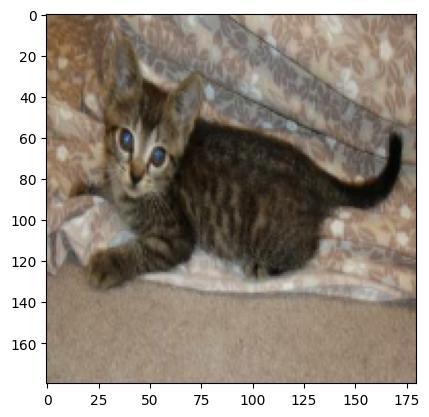

(32, 180, 180, 3)


In [ ]:
for images, _ in train_dataset.take(1):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.show()
    print(images.shape)

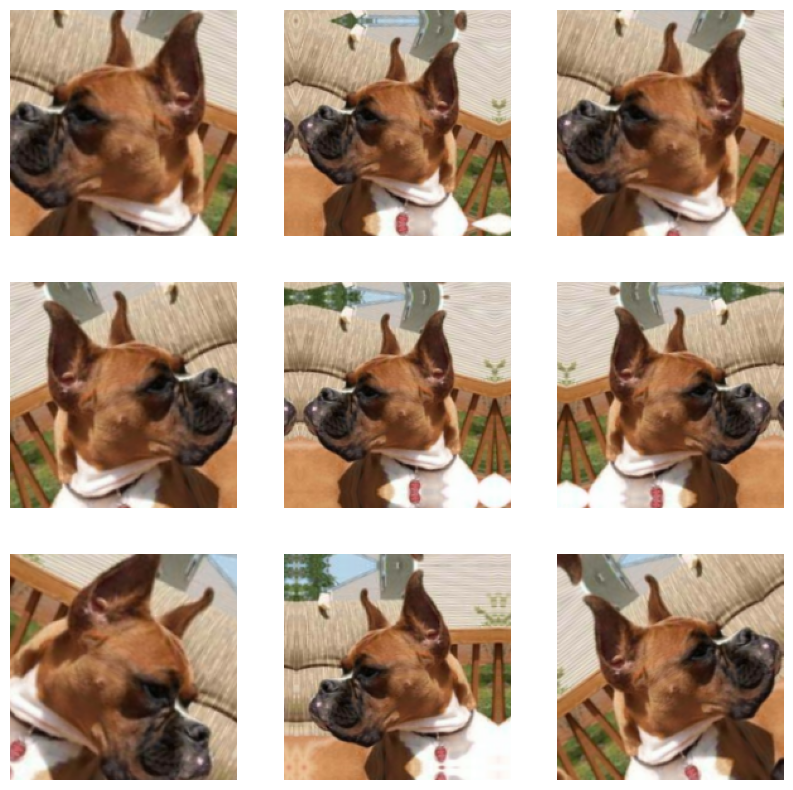

In [ ]:

plt.figure(figsize=(10,10))
for images,_ in train_dataset.take(1):  # 첫 번째 배치를 반복하여 처리하는 루프를 나타냅니다.
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

**기존 층 + 이미지 증식 + Dropout**

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3,activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs=inputs,outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch_with_augmentation.h5",
                                            save_best_only = True,
                                            monitor = "val_loss")]

history = model.fit(train_dataset,
                    epochs=100,
                    validation_data = validation_dataset,
                    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 9s 68ms/step - loss: 0.6954 - accuracy: 0.4955 - val_loss: 0.6923 - val_accuracy: 0.5050
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 6s 90ms/step - loss: 0.6943 - accuracy: 0.5100 - val_loss: 0.6928 - val_accuracy: 0.5570
Epoch 3/100
63/63 [==============================] - 7s 103ms/step - loss: 0.6926 - accuracy: 0.5115 - val_loss: 0.6934 - val_accuracy: 0.4740
Epoch 4/100
63/63 [==============================] - 4s 66ms/step - loss: 0.6929 - accuracy: 0.5055 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 6s 94ms/step - loss: 0.6931 - accuracy: 0.4945 - val_loss: 0.6880 - val_accuracy: 0.5460
Epoch 6/100
63/63 [==============================] - 8s 111ms/step - loss: 0.6899 - accuracy: 0.5135 - val_loss: 0.6888 - val_accuracy: 0.5220
Epoch 7/100
63/63 [==============================] - 5s 69ms/step - loss: 0.6857 - accuracy: 0.5415 - val_loss: 0.6676 - val_accuracy: 0.5620
Epoch 8/100
63/63 [==============================] - 7s 111ms/step - loss: 0.6748 - accuracy: 0.5785 - val_loss: 0.6647 - val_accuracy: 0.6150
Epoch 9/100
63/

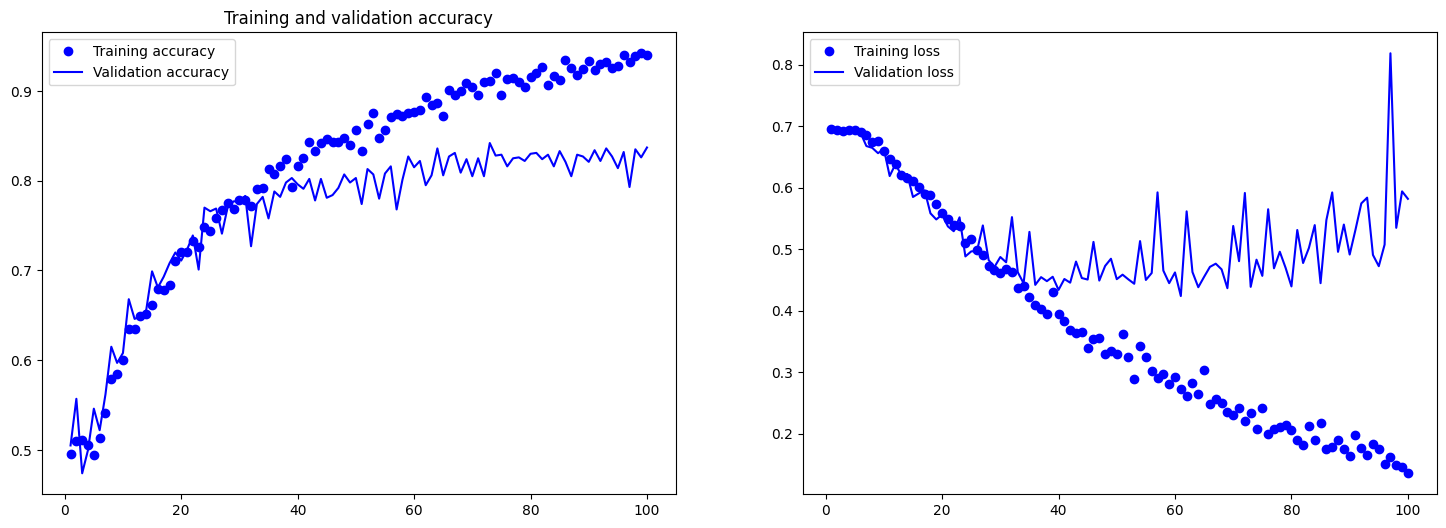

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1,len(accuracy)+1)

plt.plot(epoch,accuracy,'bo',label = 'Training accuracy')
plt.plot(epoch,val_accuracy,'b',label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch,loss,'bo',label='Training loss')
plt.plot(epoch,val_loss,'b',label='Validation loss')
plt.legend()

plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.h5")
test_loss,test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 4s 45ms/step - loss: 0.4559 - accuracy: 0.8095
테스트 정확도: 0.809


# 사전 학습된 모델 사용(ResNet)

## 1) 특성 추출

**1) 완전 연결층 재학습 = 합성곱층의 가중치는 그대로 사용하여 특성만 추출하고 완전 연결층만 다시 만들어 재학습한다**

In [ ]:
conv_base = keras.applications.resnet50.ResNet50(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (180,180,3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 186, 186, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 90, 90, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 90, 90, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

**resnet50 특성과 해당 레이블 추출하기**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.resnet50.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features,train_labels = get_features_and_labels(train_dataset)
val_features,val_labels = get_features_and_labels(validation_dataset)
test_features,test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 42ms/step


In [ ]:
train_features.shape

(2000, 6, 6, 2048)

In [ ]:
test_features.shape

(2000, 6, 6, 2048)

In [ ]:
inputs = keras.Input(shape=(6,6,2048))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callbacks=[keras.callbacks.ModelCheckpoint(filepath='feature_extraction.h5',
                                           save_best_only = True,
                                           monitor = 'val_loss')]

history = model.fit(train_features,train_labels,
                    epochs=20,
                    validation_data = (val_features,val_labels),
                    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 5s 52ms/step - loss: 8.4014 - accuracy: 0.9410 - val_loss: 2.9168 - val_accuracy: 0.9720
Epoch 2/20
63/63 [==============================] - 1s 22ms/step - loss: 2.5598 - accuracy: 0.9835 - val_loss: 3.8289 - val_accuracy: 0.9710
Epoch 3/20
63/63 [==============================] - 1s 22ms/step - loss: 0.9308 - accuracy: 0.9925 - val_loss: 4.3788 - val_accuracy: 0.9750
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 0.6741 - accuracy: 0.9935 - val_loss: 4.7617 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 1s 18ms/step - loss: 0.1526 - accuracy: 0.9980 - val_loss: 5.1248 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.4481 - accuracy: 0.9955 - val_loss: 5.6116 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 1s 18ms/step - loss: 0.1820 - accuracy: 0.9985 - val_loss: 4.9305 - val_accuracy: 0.9740
Epoch 8/20
63

**특성 추출만 사용한 밀집 연결 분류기의 훈련과 검증 지표 => 과대적합**

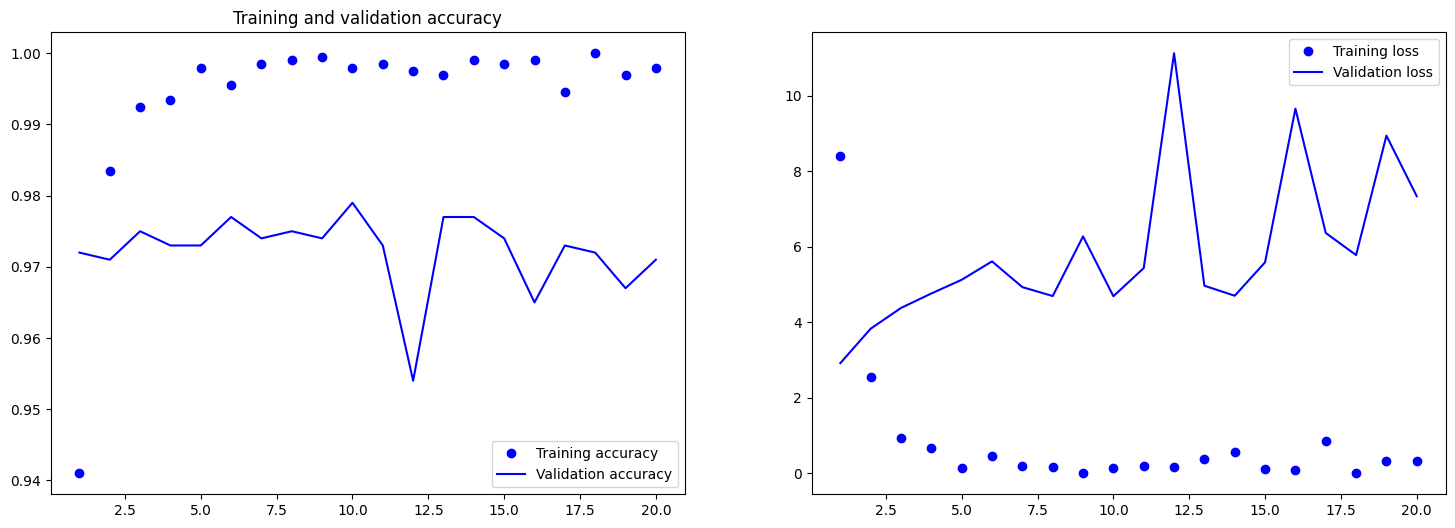

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1,len(accuracy)+1)

plt.plot(epoch,accuracy,'bo',label = 'Training accuracy')
plt.plot(epoch,val_accuracy,'b',label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch,loss,'bo',label='Training loss')
plt.plot(epoch,val_loss,'b',label='Validation loss')
plt.legend()

plt.show()

In [ ]:
import tensorflow as tf
# 특징과 라벨을 기반으로 평가 데이터셋 생성
test_dataset_ = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset_ = test_dataset.batch(2000)

# 모델 평가
test_model = keras.models.load_model("feature_extraction.h5")
loss, accuracy = test_model.evaluate(test_dataset_)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 6, 6, 2048), found shape=(None, None, 6, 6, 2048)


## 2) 데이터 증식을 사용한 특성 추출

**합성곱 층을 동결하고 데이터 증식 후 완전 연결층 재학습**

In [ ]:
conv_base = keras.applications.resnet50.ResNet50(weights = 'imagenet',
                                                 include_top = False)
conv_base.trainable = False     # 동결

In [ ]:
conv_base.trainable = True
print("합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))
conv_base.trainable = False
print("합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수: 212
합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수: 0


In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)])

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)
model = keras.Model(inputs,outputs)

model.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
callbacks=[keras.callbacks.ModelCheckpoint(filepath='feature_extraction_with_data_augmentation.h5',
                                           save_best_only = True,
                                           monitor = 'val_loss')]

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data = validation_dataset,
                    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 7.9845 - accuracy: 0.9315

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 18s 171ms/step - loss: 7.9845 - accuracy: 0.9315 - val_loss: 4.6257 - val_accuracy: 0.9720
Epoch 2/50
63/63 [==============================] - 13s 197ms/step - loss: 6.5222 - accuracy: 0.9590 - val_loss: 3.9114 - val_accuracy: 0.9750
Epoch 3/50
63/63 [==============================] - 10s 161ms/step - loss: 4.2892 - accuracy: 0.9695 - val_loss: 3.7692 - val_accuracy: 0.9780
Epoch 4/50
63/63 [==============================] - 11s 177ms/step - loss: 3.2780 - accuracy: 0.9765 - val_loss: 4.5785 - val_accuracy: 0.9750
Epoch 5/50
63/63 [==============================] - 9s 141ms/step - loss: 3.2227 - accuracy: 0.9785 - val_loss: 3.8266 - val_accuracy: 0.9780
Epoch 6/50
63/63 [==============================] - 8s 130ms/step - loss: 3.8781 - accuracy: 0.9740 - val_loss: 4.1570 - val_accuracy: 0.9780
Epoch 7/50
63/63 [==============================] - 12s 180ms/step - loss: 2.1275 - accuracy: 0.9830 - val_loss: 4.7448 - val_accuracy: 0.9750
Epoch 8/50
6

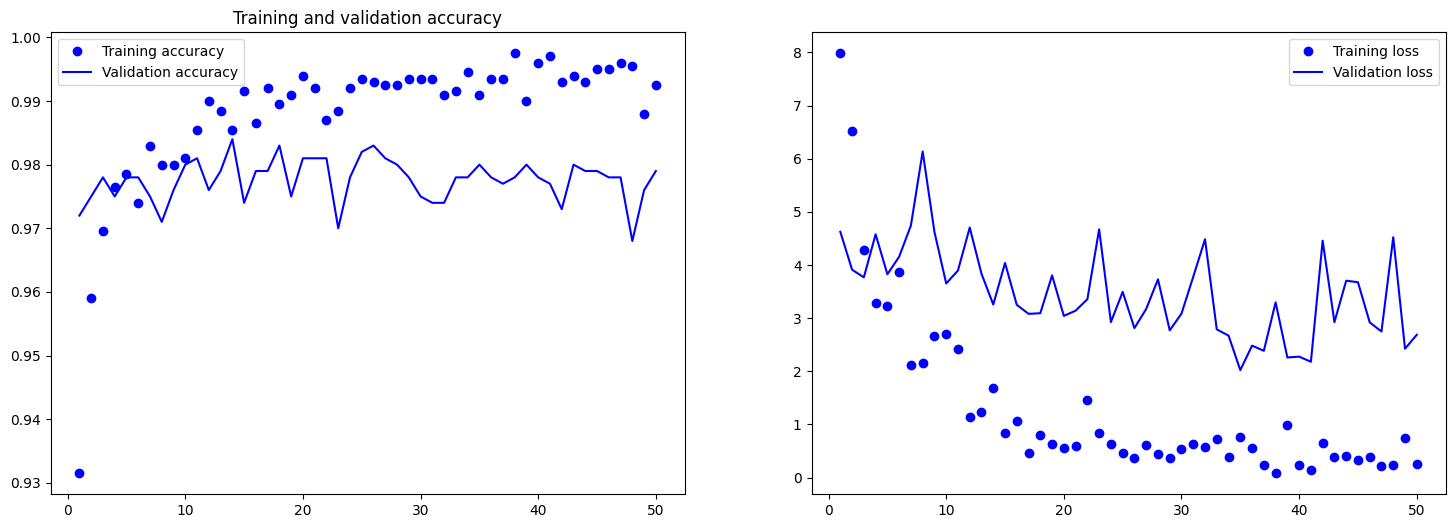

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1,len(accuracy)+1)

plt.plot(epoch,accuracy,'bo',label = 'Training accuracy')
plt.plot(epoch,val_accuracy,'b',label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch,loss,'bo',label='Training loss')
plt.plot(epoch,val_loss,'b',label='Validation loss')
plt.legend()

plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.h5")
test_loss,test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(None, 6, 6, 2048)


# 사전 학습된 모델 미세 조정하기(vgg16)

In [70]:
conv_base = keras.applications.vgg16.VGG16(weights = 'imagenet',
                                           include_top = False,
                                           input_shape = (180,180,3))

58889256/58889256 [==============================] - 0s 0us/step


In [71]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**최상위 4개층만 학습**

In [72]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [73]:
model.compile(loss='binary_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate = 1e-5),
              metrics = ['accuracy'])

callbacks=[keras.callbacks.ModelCheckpoint(filepath='fine_tuning.h5',
                                           save_best_only = True,
                                           monitor = 'val_loss')]

history = model.fit(train_dataset,
                    epochs=30,
                    validation_data = validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 189ms/step - loss: 0.0913 - accuracy: 0.9975 - val_loss: 2.7071 - val_accuracy: 0.9790
Epoch 2/30
63/63 [==============================] - 9s 132ms/step - loss: 0.3203 - accuracy: 0.9940 - val_loss: 2.9227 - val_accuracy: 0.9760
Epoch 3/30
63/63 [==============================] - 11s 164ms/step - loss: 0.1138 - accuracy: 0.9960 - val_loss: 3.0465 - val_accuracy: 0.9750
Epoch 4/30
63/63 [==============================] - 11s 165ms/step - loss: 0.3206 - accuracy: 0.9965 - val_loss: 3.0931 - val_accuracy: 0.9760
Epoch 5/30
63/63 [==============================] - 8s 130ms/step - loss: 0.3012 - accuracy: 0.9960 - val_loss: 3.0953 - val_accuracy: 0.9760
Epoch 6/30
63/63 [==============================] - 12s 196ms/step - loss: 0.1786 - accuracy: 0.9970 - val_loss: 3.1955 - val_accuracy: 0.9750
Epoch 7/30
63/63 [==============================] - 12s 185ms/step - loss: 0.1135 - accuracy: 0.9965 - val_loss: 3.1972 - val_accuracy: 0.9750
E

In [74]:
model = keras.models.load_model("fine_tuning.h5")
test_loss,test_acc = model.evaluate(test_dataset)
print(f"테스트 정확도:{test_acc:.3f}")

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(None, 6, 6, 2048)
